In [9]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score,classification_report,roc_auc_score, roc_curve
from sklearn.datasets import load_boston
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier


from xgboost import XGBRegressor, XGBClassifier
    
import matplotlib.pyplot as plt

In [10]:
from sklearn.datasets import load_boston

In [11]:
bhp = load_boston()
print(bhp.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

C:\Users\kandanulus\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing data

In [4]:
bhp = pd.read_csv('boston_house_prices.csv')

In [5]:
bhp.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7


In [8]:
X = bhp.drop(columns='MEDV')
y = bhp.MEDV

In [ ]:
# train, test = train_test_split(bhp,test_size=.33,random_state=42)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
sc = StandardScaler()

In [13]:
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [32]:
sgd_reg = SGDRegressor(random_state=2022)

In [33]:
sgd_reg.fit(X_train_std,y_train.values)

SGDRegressor(random_state=2022)

In [35]:
medv_pred = sgd_reg.predict(X_test_std)

In [38]:
df_validation = pd.DataFrame({'medv_actual':y_test,'medv_pred':medv_pred})
df_validation

,medv_actual,medv_pred
173,23.6,28.414975
274,32.4,36.138594
491,13.6,16.807925
72,22.8,25.442495
452,16.1,18.764191
...,...,...
110,21.7,21.387833
321,23.1,25.010961
265,22.8,27.359265
29,21.0,20.968473


In [41]:
((df_validation.medv_actual - df_validation.medv_pred)**2).mean()

21.17002669359018

In [43]:
mean_squared_error(y_test,medv_pred)

21.17002669359017

In [46]:
mean_squared_error(y_test,medv_pred,squared=False)  # RMSE

4.601089728921853

In [47]:
mean_squared_error(y_train,sgd_reg.predict(X_train_std),squared=False)

4.80468801363288

### Coefficient of determination

In [50]:
sgd_reg.score(X_train_std,y_train.values)

0.7380998091037393

## Minibatch Stochastic Gradient Descent

In [100]:
def iter_mb(batch_size = 1):    
    
    start = 0
    
    while start < X_train_std.shape[0]:
        rows = range(start, start + batch_size)
        
        X_batch = X_train_std[rows,:]
        y_batch = y_train[rows]
        
        yield X_batch, y_batch
        start = start + batch_size

In [101]:
batch_iterator = iter_mb(batch_size = 113)

In [102]:
sgd_reg = SGDRegressor()

In [103]:
for X_, y_ in batch_iterator:
    sgd_reg.partial_fit(X_,y_)

In [104]:
mean_squared_error(y_test,sgd_reg.predict(X_test_std))

84.40913502331564

## Cross Validation

In [6]:
train, test = train_test_split(bhp,test_size=.33,random_state=42)

In [7]:
train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
478,10.23300,0.0,18.10,0,0.614,6.185,96.7,2.1705,24,666,20.2,379.70,18.03,14.6
26,0.67191,0.0,8.14,0,0.538,5.813,90.3,4.6820,4,307,21.0,376.88,14.81,16.6
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1
492,0.11132,0.0,27.74,0,0.609,5.983,83.5,2.1099,4,711,20.1,396.90,13.35,20.1
108,0.12802,0.0,8.56,0,0.520,6.474,97.1,2.4329,5,384,20.9,395.24,12.27,19.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.17120,0.0,8.56,0,0.520,5.836,91.9,2.2110,5,384,20.9,395.67,18.66,19.5
270,0.29916,20.0,6.96,0,0.464,5.856,42.1,4.4290,3,223,18.6,388.65,13.00,21.1
348,0.01501,80.0,2.01,0,0.435,6.635,29.7,8.3440,4,280,17.0,390.94,5.99,24.5
435,11.16040,0.0,18.10,0,0.740,6.629,94.6,2.1247,24,666,20.2,109.85,23.27,13.4


In [8]:
train = train.sample(frac=1,random_state=2022).reset_index(drop=True)

In [9]:
train['kfold'] = -999

In [10]:
train.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,kfold
0,0.26938,0.0,9.9,0,0.544,6.266,82.8,3.2628,4,304,18.4,393.39,7.90,21.6,-999
1,4.83567,0.0,18.1,0,0.583,5.905,53.2,3.1523,24,666,20.2,388.22,11.45,20.6,-999


In [11]:
kf = KFold(n_splits=5)

In [12]:
# lst = ['a','b','c']
# for i in enumerate(lst,start=1):
#     print(i)

In [13]:
for fold, (t,v) in enumerate(kf.split(train)):
    train.loc[v,'kfold'] = fold
    
    #print(fold,(t,v))

In [14]:
train.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,kfold
0,0.26938,0.0,9.90,0,0.544,6.266,82.8,3.2628,4,304,18.4,393.39,7.90,21.6,0
1,4.83567,0.0,18.10,0,0.583,5.905,53.2,3.1523,24,666,20.2,388.22,11.45,20.6,0
2,1.34284,0.0,19.58,0,0.605,6.066,100.0,1.7573,5,403,14.7,353.89,6.43,24.3,0
3,28.65580,0.0,18.10,0,0.597,5.155,100.0,1.5894,24,666,20.2,210.97,20.08,16.3,0
4,0.57529,0.0,6.20,0,0.507,8.337,73.3,3.8384,8,307,17.4,385.91,2.47,41.7,0


In [15]:
train.groupby('kfold')[['kfold']].count()

,kfold
kfold,
0,68
1,68
2,68
3,68
4,67


In [16]:
train.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV', 'kfold'],
      dtype='object')

In [19]:
x_vars = [var for var in train.columns if var not in ['MEDV', 'kfold']]

In [23]:
sgd = SGDRegressor(random_state=2022)

In [25]:
sc = StandardScaler()

In [35]:
final_pred_lst = []
rmse = []

param = []
for fold in range(5):
    
    train_cv = train[train.kfold != fold]
    test_cv = train[train.kfold == fold]
    
    y_train = train_cv['MEDV']
    y_test = test_cv['MEDV']
    
    x_train = train_cv[x_vars]
    x_test = test_cv[x_vars]
    
    x_train_std = sc.fit_transform(x_train)
    x_test_std = sc.transform(x_test)
    
    
    sgd.fit(x_train_std, y_train)
    
    pred_test = sgd.predict(x_test_std)
    
    x_deploy_std = sc.transform(test[x_vars])
    
    final_pred = sgd.predict(x_deploy_std)
    
    rmse.append(mean_squared_error(y_test,pred_test,squared=False))
    
    final_pred_lst.append(final_pred)
    
    param.append(sgd.coef_)
    
    print(fold, mean_squared_error(y_test,pred_test,squared=False))

0 4.727464674829044
1 5.528386959309025
2 4.061059476309088
3 3.9848092266990327
4 6.429927069431654


In [29]:
rmse

[4.727464674829044,
 5.528386959309025,
 4.061059476309088,
 3.9848092266990327,
 6.429927069431654]

In [30]:
final_pred_lst

[array([ 2.88799946e+01,  3.59214586e+01,  1.62974841e+01,  2.55253999e+01,
         1.86254835e+01,  2.34567703e+01,  1.78591311e+01,  1.45834448e+01,
         2.26516622e+01,  2.11839198e+01,  2.46565619e+01,  1.85979724e+01,
        -6.02272538e+00,  2.21241524e+01,  1.97398688e+01,  2.56588726e+01,
         1.95843949e+01,  5.94895343e+00,  3.91936940e+01,  1.74207726e+01,
         2.72941083e+01,  2.96905487e+01,  1.19337949e+01,  2.44462243e+01,
         1.79020900e+01,  1.58537535e+01,  2.34273428e+01,  1.44101876e+01,
         2.26603014e+01,  1.99504436e+01,  2.26579300e+01,  2.54636216e+01,
         2.49024052e+01,  1.83570256e+01,  1.64635594e+01,  1.74203258e+01,
         3.09507666e+01,  2.06172289e+01,  2.41405042e+01,  2.49952212e+01,
         1.47609553e+01,  3.13970199e+01,  4.08656419e+01,  1.82642486e+01,
         2.75422844e+01,  1.70696011e+01,  1.47187857e+01,  2.61801708e+01,
         2.00198888e+01,  3.03138867e+01,  2.12976542e+01,  3.35302759e+01,
         1.6

In [32]:
np.mean(np.column_stack(final_pred_lst),axis=1)

array([28.34520721, 36.33102171, 16.83601558, 25.39165434, 18.82427369,
       23.16615667, 17.35886407, 14.40879693, 22.61779524, 20.76967598,
       24.73145819, 18.49491105, -5.95618711, 21.98864207, 19.03772849,
       26.01204759, 19.31246062,  5.75051879, 39.73153513, 17.62444094,
       27.07789554, 29.58712804, 11.02142096, 24.05354414, 18.02078429,
       15.66737794, 23.3078747 , 14.58938203, 22.42678841, 19.56068822,
       21.86256856, 25.05788593, 25.44285353, 18.46634832, 16.30327759,
       17.99611622, 30.79388525, 19.94919505, 24.13660312, 24.88121805,
       14.19444556, 30.80811825, 41.47484887, 17.85921005, 26.97353951,
       17.10851881, 13.81609434, 26.11003395, 20.05201416, 30.28475231,
       21.23159448, 33.53280358, 15.66470384, 26.29329143, 38.9129956 ,
       22.89034202, 18.93381689, 32.19017062, 24.71627603, 12.8121945 ,
       22.3787001 , 30.08165929, 31.32261712, 16.46239381, 21.71291851,
       16.67198172, 20.30156111, 25.94298243, 30.49396237, 11.91

In [34]:
param

[array([-0.91087252,  0.52993232, -0.08898891,  0.82191116, -1.75743435,
         2.78635451, -0.2751313 , -2.98125841,  1.39133042, -0.87548779,
        -1.79472779,  1.00475511, -3.79564777]),
 array([-0.37186456,  0.65993185,  0.33715493,  0.98811186, -1.37824222,
         3.17122818, -0.67997827, -2.54151232,  1.25839159, -0.64612266,
        -1.99692831,  1.11032725, -4.01858337]),
 array([-0.92172263,  0.63388318, -0.00499632,  1.11389525, -1.08150927,
         2.91278773, -0.31700001, -2.59564889,  0.95927578, -0.17600656,
        -2.098587  ,  1.12121747, -4.16177789]),
 array([-1.12617702,  0.70845959,  0.17778608,  0.83884781, -1.85034259,
         2.78777199, -0.08474836, -2.98940397,  1.55633497, -0.47720417,
        -1.93403011,  0.91068495, -4.40561952]),
 array([-0.8626316 ,  0.6831068 ,  0.39354667,  0.95335961, -1.68464805,
         2.97610466, -0.67902598, -2.76987726,  1.18174605, -0.97261911,
        -2.17108074,  1.15340185, -3.00690351])]

## Classification

In [12]:
bc = load_breast_cancer()

print(bc.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [13]:
bc_data = pd.DataFrame(bc.data,columns=bc.feature_names)
bc_data['target'] = bc.target

In [42]:
bc_data.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [89]:
sgd_class = SGDClassifier(loss='log',random_state=2022)

In [88]:
# train_bc, test_bc = train_test_split(bc_data, test_size=.2,random_state=2022)

In [14]:
y = bc_data.target
X = bc_data.drop(columns='target')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2022)

In [80]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [81]:
np.arange(100,2000)

array([ 100,  101,  102, ..., 1997, 1998, 1999])

In [82]:
penalty = ['l2', 'l1', 'elasticnet']
alpha = [.001,.1,1,10,100,1000]
l1_ratio = [.01,.1,.9,.8,.6]
learning_rate = ['constant','adaptive']
eta0 = [.001,.1,.02,.2,.8,1,10,100]

In [83]:
param_dist = dict(penalty=penalty,alpha=alpha,l1_ratio=l1_ratio,learning_rate=learning_rate,eta0=eta0)

In [84]:
param_dist

{'penalty': ['l2', 'l1', 'elasticnet'],
 'alpha': [0.001, 0.1, 1, 10, 100, 1000],
 'l1_ratio': [0.01, 0.1, 0.9, 0.8, 0.6],
 'learning_rate': ['constant', 'adaptive'],
 'eta0': [0.001, 0.1, 0.02, 0.2, 0.8, 1, 10, 100]}

In [85]:
grid_class = GridSearchCV(estimator = sgd_class,param_grid=param_dist,n_jobs=-1)

In [86]:
grid_class.fit(X_train_std,y_train)

GridSearchCV(estimator=SGDClassifier(loss='log', random_state=2022), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 100, 1000],
                         'eta0': [0.001, 0.1, 0.02, 0.2, 0.8, 1, 10, 100],
                         'l1_ratio': [0.01, 0.1, 0.9, 0.8, 0.6],
                         'learning_rate': ['constant', 'adaptive'],
                         'penalty': ['l2', 'l1', 'elasticnet']})

In [87]:
grid_class.best_estimator_

SGDClassifier(alpha=0.001, eta0=0.001, l1_ratio=0.01, learning_rate='constant',
              loss='log', random_state=2022)

In [62]:
import sklearn

In [91]:
sklearn.__version__

'1.0.2'

In [90]:
grid_class.predict(X_test_std)

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [94]:
bc_data.target.value_counts()

1    357
0    212
Name: target, dtype: int64

In [93]:
pd.crosstab(y_test,grid_class.predict(X_test_std))   # confusion matrix

col_0,0,1
target,,
0,71,2
1,2,113


In [95]:
(71+113)/len(y_test)

0.9787234042553191

In [96]:
accuracy_score(y_test,grid_class.predict(X_test_std))

0.9787234042553191

In [98]:
grid_class.predict_proba(X_test_std).shape

(188, 2)

In [104]:
grid_class.predict_proba(X_test_std)[:,0]

array([1.00961892e-01, 2.37915879e-03, 5.77579170e-01, 8.24401305e-03,
       1.21379703e-01, 1.36498164e-02, 5.79929347e-01, 9.94857360e-01,
       9.43051986e-01, 9.99999974e-01, 9.99999659e-01, 7.50630275e-01,
       9.60081006e-01, 9.94757081e-01, 2.75255347e-01, 9.88923623e-03,
       5.97068205e-02, 8.44767197e-03, 3.40685572e-01, 9.93896027e-04,
       3.57076541e-02, 1.74627004e-02, 7.46848661e-02, 5.02523547e-02,
       6.03997733e-01, 4.69606746e-03, 4.75998100e-02, 1.42854701e-04,
       9.85154833e-01, 5.28955721e-03, 2.32374047e-02, 1.70208310e-02,
       9.99734136e-01, 5.83896736e-01, 2.79086216e-02, 9.83488911e-01,
       9.93049153e-01, 4.26336273e-04, 9.99764906e-01, 3.84763167e-02,
       3.46188176e-02, 9.14088548e-01, 9.98976926e-01, 3.10374760e-04,
       9.59159111e-01, 1.08694758e-03, 9.99528233e-01, 2.29924734e-03,
       9.99999975e-01, 9.99999721e-01, 9.67793709e-02, 8.58256764e-01,
       6.70180704e-01, 1.02691400e-02, 9.99997168e-01, 9.40243380e-01,
      

In [101]:
np.sum(grid_class.predict_proba(X_test_std),axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

In [105]:
pred_prob = grid_class.predict_proba(X_test_std)[:,0]

In [106]:
pred_class = grid_class.predict(X_test_std)

In [127]:
pred_class

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [108]:
print(classification_report(y_test,pred_class))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        73
           1       0.98      0.98      0.98       115

    accuracy                           0.98       188
   macro avg       0.98      0.98      0.98       188
weighted avg       0.98      0.98      0.98       188



In [116]:
fpr, tpr, threshhold = roc_curve(y_true = y_test, y_score = pred_prob, pos_label=0)

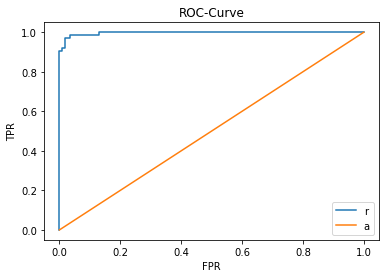

In [125]:
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.legend('random classification line')
plt.title('ROC-Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
# plt.legend()
plt.show()

## Stratified kfold

In [128]:
skf = StratifiedKFold()

In [134]:
train = train.sample(frac=1,random_state=2022).reset_index(drop=True)

In [135]:
train['sk_fold'] = 9999

In [144]:
train['y_strata'] = pd.cut(train.MEDV,4,labels=[0,1,2,3])

In [145]:
pd.cut(train.MEDV,4,labels=[0,1,2,3]).value_counts()

1    177
0     84
2     55
3     23
Name: MEDV, dtype: int64

In [137]:
train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,kfold,sk_fold
0,5.87205,0.0,18.10,0,0.693,6.405,96.0,1.6768,24,666,20.2,396.90,19.37,12.5,3,9999
1,0.01501,80.0,2.01,0,0.435,6.635,29.7,8.3440,4,280,17.0,390.94,5.99,24.5,2,9999
2,0.04113,25.0,4.86,0,0.426,6.727,33.5,5.4007,4,281,19.0,396.90,5.29,28.0,0,9999
3,0.08664,45.0,3.44,0,0.437,7.178,26.3,6.4798,5,398,15.2,390.49,2.87,36.4,4,9999
4,0.33983,22.0,5.86,0,0.431,6.108,34.9,8.0555,7,330,19.1,390.18,9.16,24.3,3,9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,0.10612,30.0,4.93,0,0.428,6.095,65.1,6.3361,6,300,16.6,394.62,12.40,20.1,3,9999
335,11.81230,0.0,18.10,0,0.718,6.824,76.5,1.7940,24,666,20.2,48.45,22.74,8.4,0,9999
336,0.04301,80.0,1.91,0,0.413,5.663,21.9,10.5857,4,334,22.0,382.80,8.05,18.2,3,9999
337,25.04610,0.0,18.10,0,0.693,5.987,100.0,1.5888,24,666,20.2,396.90,26.77,5.6,1,9999


In [148]:
for fold, (t,v) in enumerate(skf.split(train,train['y_strata'])):
    train.loc[v,'sk_fold'] = fold

In [151]:
train.groupby(['sk_fold','y_strata'])[['MEDV']].count()

MEDV
sk_fold y_strata      
0       0           17
        1           36
        2           11
        3            4
1       0           17
        1           35
        2           11
        3            5
2       0           17
        1           35
        2           11
        3            5
3       0           17
        1           35
        2           11
        3            5
4       0           16
        1           36
        2           11
        3            4

## Decision Trees

In [153]:
dt = DecisionTreeClassifier()

In [156]:
dt.fit(X_train,y_train)

DecisionTreeClassifier()

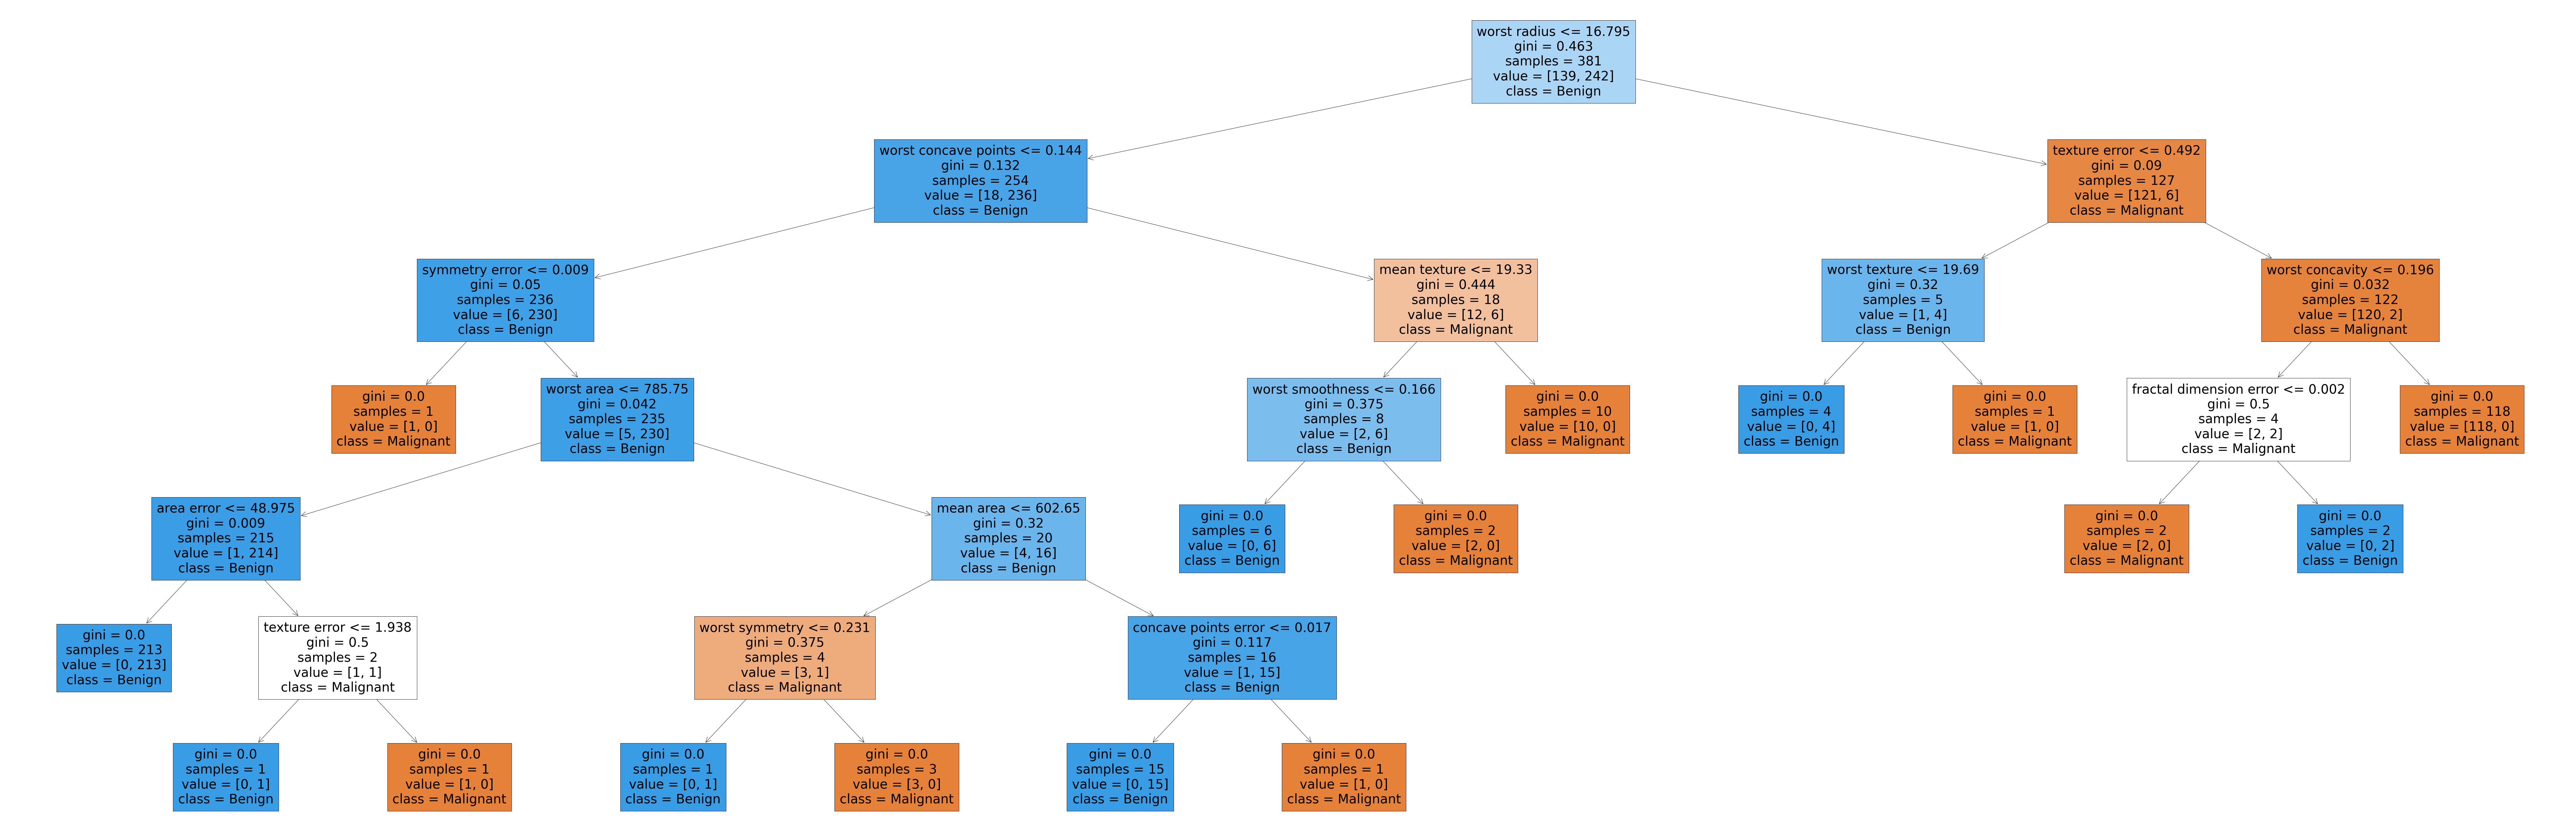

In [167]:
plt.figure(figsize=(150,50))
tree.plot_tree(dt,feature_names=list(X_train.columns),filled=True,class_names=['Malignant','Benign'],)
plt.savefig('dt.jpg',edgecolor='auto',facecolor='auto')

plt.show()

In [168]:
def gini_calc(c1,c2):
    return 1-pow(c1/(c1+c2),2)-pow(c2/(c1+c2),2)

In [169]:
gini_calc(139,242)

0.46345781580452056

In [172]:
gini_calc(1,3)

0.375

### Decision tree pruning

In [ ]:
min_samples_split: The minimum number of samples required to split an internal node
min_samples_leaf: The minimum number of samples required to be at a leaf node

In [175]:
X_train.shape[0]*.03

11.43

In [177]:
dt_pruned = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=15)

In [179]:
dt_pruned.fit(X_train,y_train)

DecisionTreeClassifier(min_samples_leaf=15, min_samples_split=30)

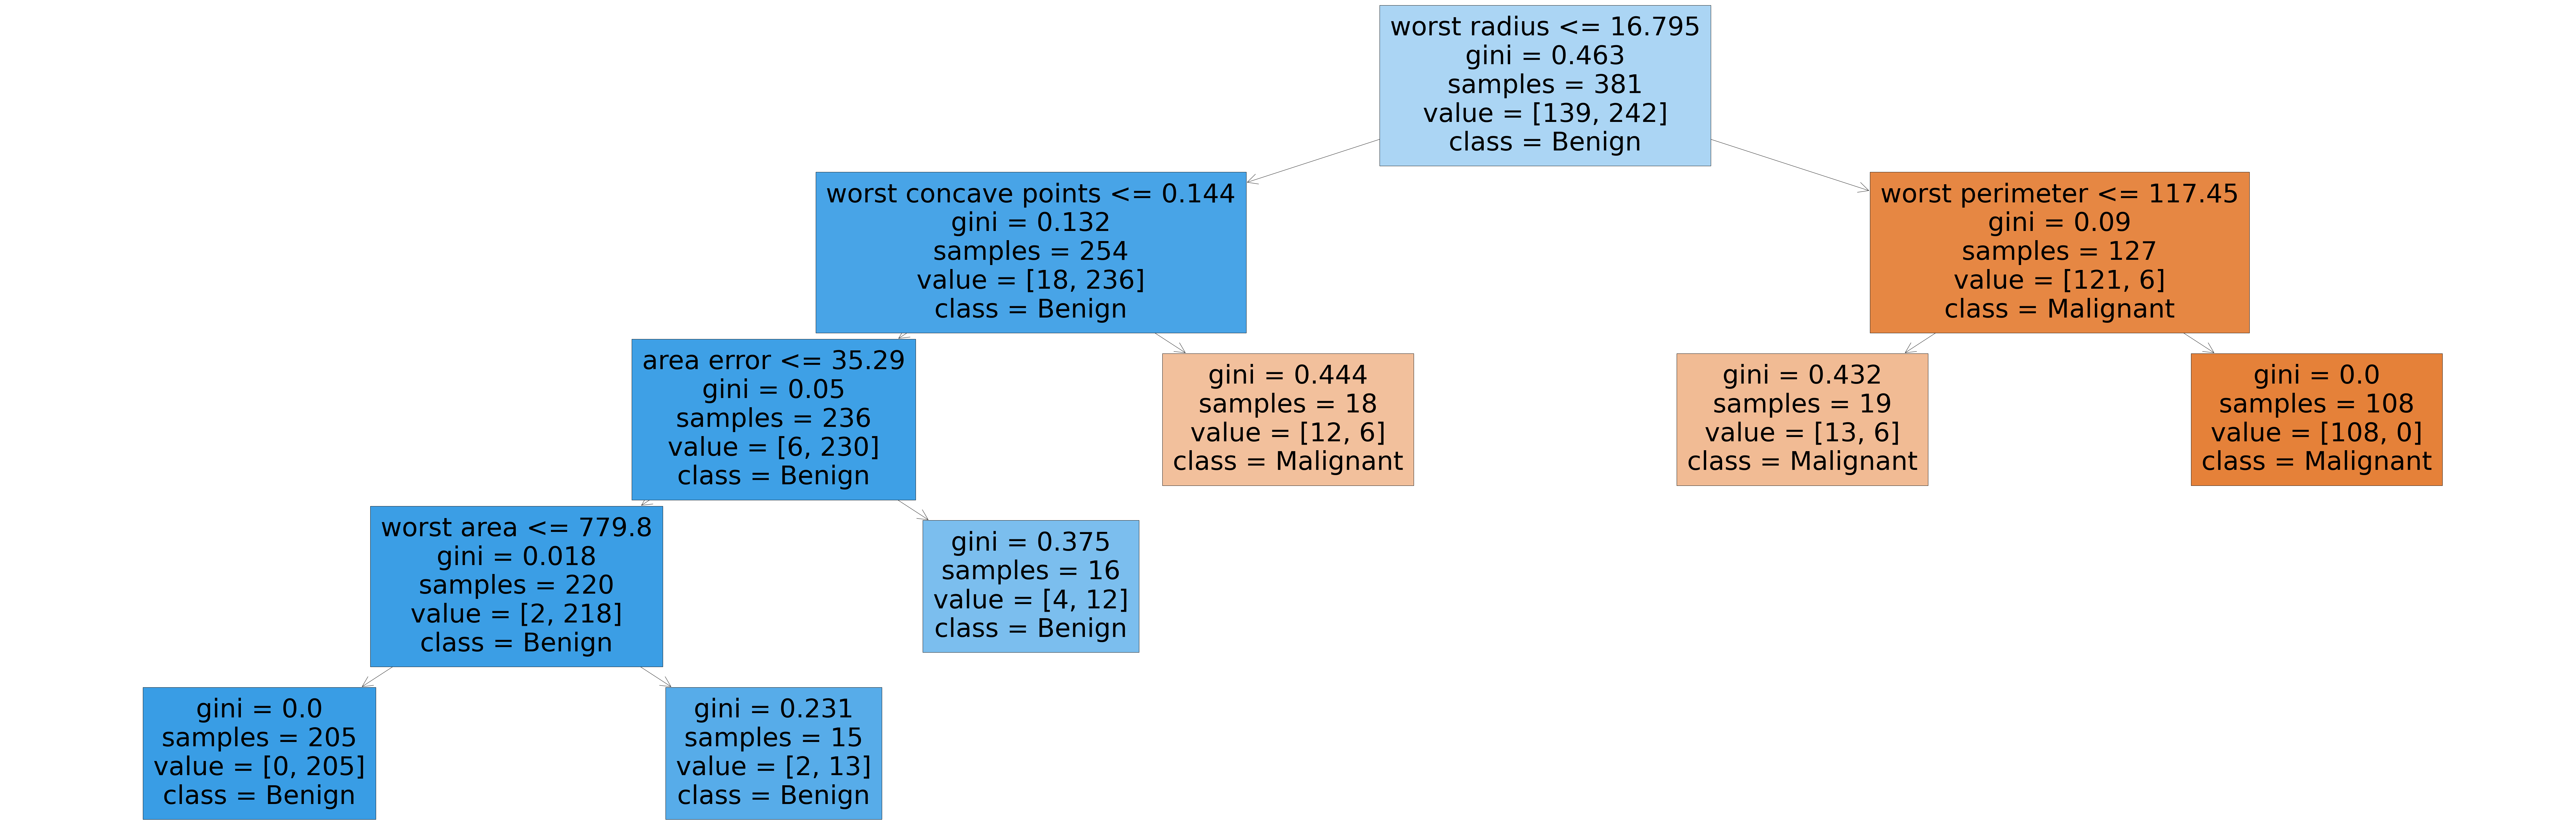

In [180]:
plt.figure(figsize=(150,50))
tree.plot_tree(dt_pruned,feature_names=list(X_train.columns),filled=True,class_names=['Malignant','Benign'],)
plt.savefig('dt.jpg',edgecolor='auto',facecolor='auto')

plt.show()

## Random Forest

In [7]:
rf = RandomForestClassifier(oob_score=True, random_state=2022)

In [8]:
n_estimators = np.arange(2,10)
criterion = ['gini','entropy']
min_samples_split =  [30,40,50]
min_samples_leaf = np.arange(15,20)
max_features = ['auto','log2']                  # The number of features to consider when looking for the best spli

In [9]:
param_rf = dict(n_estimators=n_estimators,criterion=criterion,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,max_features=max_features)

In [10]:
param_rf

{'n_estimators': array([2, 3, 4, 5, 6, 7, 8, 9]),
 'criterion': ['gini', 'entropy'],
 'min_samples_split': [30, 40, 50],
 'min_samples_leaf': array([15, 16, 17, 18, 19]),
 'max_features': ['auto', 'log2']}

In [11]:
rf_random = RandomizedSearchCV(estimator=rf,param_distributions=param_rf,n_iter=20,cv=5,random_state=2022,n_jobs=-1)

In [16]:
rf_random.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(oob_score=True,
                                                    random_state=2022),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': array([15, 16, 17, 18, 19]),
                                        'min_samples_split': [30, 40, 50],
                                        'n_estimators': array([2, 3, 4, 5, 6, 7, 8, 9])},
                   random_state=2022)

In [17]:
rf_random.best_estimator_

RandomForestClassifier(max_features='log2', min_samples_leaf=18,
                       min_samples_split=30, n_estimators=4, oob_score=True,
                       random_state=2022)

In [18]:
rf_random.predict(X_test)

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1])

In [19]:
pd.crosstab(y_test,rf_random.predict(X_test))

col_0,0,1
target,,
0,61,12
1,9,106


In [20]:
accuracy_score(y_test,rf_random.predict(X_test))

0.8882978723404256

## XGBOOST with pipelines

In [2]:
housing = pd.read_excel('housing.xlsx')

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [5]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [46]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
1. Missing value imputation - numeric var
2. Dealing with categorical data - dummy variables - object type
3. Standardisation - numeric
4. model building

SyntaxError: invalid syntax (182621139.py, line 1)

In [7]:
train_housing, test_housing = train_test_split(housing, test_size=.2,random_state=2020)

In [8]:
num_cols = train_housing.select_dtypes(exclude='object').columns
obj_cols = train_housing.select_dtypes(include='object').columns

In [9]:
num_pipeline = Pipeline([('si',SimpleImputer(strategy='median')),('std',StandardScaler())])

In [10]:
num_pipeline.fit_transform(train_housing[num_cols])

array([[ 1.16842958, -1.3244009 , -0.13162188, ..., -0.43017112,
        -0.74361175,  0.32552794],
       [ 1.11848844, -0.7295211 ,  0.26630922, ..., -0.23344986,
        -0.71215987, -1.02239844],
       [-1.04895737,  0.70381135, -0.76831165, ..., -0.12853186,
         0.92476511,  0.81536716],
       ...,
       [ 1.28329422, -1.35250546, -0.92748409, ...,  0.02359924,
        -1.04951432, -0.7653197 ],
       [ 0.66901811, -0.79978249,  0.26630922, ...,  0.2937631 ,
        -1.40018956, -0.86606677],
       [ 0.72395337, -0.43910733, -0.13162188, ...,  0.05769759,
        -0.04791731, -0.81135069]])

In [35]:
preprocessing_pipeline = ColumnTransformer([('num',num_pipeline,num_cols),('ohe',OneHotEncoder(handle_unknown='ignore'),obj_cols)])

In [36]:
preprocessing_pipeline.fit_transform(train_housing)

array([[ 1.16842958, -1.3244009 , -0.13162188, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.11848844, -0.7295211 ,  0.26630922, ...,  0.        ,
         0.        ,  0.        ],
       [-1.04895737,  0.70381135, -0.76831165, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.28329422, -1.35250546, -0.92748409, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66901811, -0.79978249,  0.26630922, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72395337, -0.43910733, -0.13162188, ...,  0.        ,
         0.        ,  0.        ]])

In [37]:
train_std = preprocessing_pipeline.fit_transform(train_housing)

In [38]:
pd.DataFrame(train_std)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.168430,-1.324401,-0.131622,-0.615434,-0.437731,-0.575403,-0.430171,-0.743612,0.325528,0.0,0.0,0.0,0.0,1.0
1,1.118488,-0.729521,0.266309,-0.255332,-0.192189,-0.067923,-0.233450,-0.712160,-1.022398,0.0,1.0,0.0,0.0,0.0
2,-1.048957,0.703811,-0.768312,0.284592,-0.132592,-0.043381,-0.128532,0.924765,0.815367,1.0,0.0,0.0,0.0,0.0
3,0.639053,-0.785730,0.266309,-0.878322,-0.795315,-0.517555,-0.768532,-1.198950,-1.018056,1.0,0.0,0.0,0.0,0.0
4,0.569136,-0.659260,0.425482,-0.157662,-0.261322,0.012713,-0.120663,0.208561,0.232597,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-1.243728,0.633550,-1.086657,0.337535,0.310813,0.121396,0.299009,0.187311,0.989938,0.0,0.0,0.0,0.0,1.0
16508,1.058559,-0.757626,-0.211208,0.180989,0.141556,0.251991,0.131140,-0.587304,-0.970288,0.0,1.0,0.0,0.0,0.0
16509,1.283294,-1.352505,-0.927484,-0.131647,0.143940,-0.008322,0.023599,-1.049514,-0.765320,1.0,0.0,0.0,0.0,0.0
16510,0.669018,-0.799782,0.266309,0.023986,0.241680,0.456210,0.293763,-1.400190,-0.866067,1.0,0.0,0.0,0.0,0.0


In [39]:
pd.DataFrame(train_std).isna().any()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
dtype: bool

In [40]:
pd.DataFrame(train_std).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-4.496975e-15,6.650782e-16,6.294592e-17,1.070234e-16,9.154532e-17,-6.003622e-17,-6.056740e-17,2.037624e-16,-3.181671e-17,0.444949,0.314559,0.000242,0.111374,0.128876
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,0.496975,0.464354,0.015563,0.314604,0.335073
min,-2.387380e+00,-1.446187e+00,-2.200864e+00,-1.206476e+00,-1.281630e+00,-1.252919e+00,-1.311482e+00,-1.782000e+00,-1.666841e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.113881e+00,-7.950984e-01,-8.478979e-01,-5.446917e-01,-5.712290e-01,-5.631322e-01,-5.770563e-01,-6.902757e-01,-7.548976e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.391711e-01,-6.452074e-01,2.755056e-02,-2.363917e-01,-2.446351e-01,-2.309475e-01,-2.386958e-01,-1.755485e-01,-2.303180e-01,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.788886e-01,9.754887e-01,6.642403e-01,2.302801e-01,2.559834e-01,2.633855e-01,2.754025e-01,4.633343e-01,4.992298e-01,1.000000,1.000000,0.000000,0.000000,0.000000
max,2.626711e+00,2.961544e+00,1.858034e+00,1.673837e+01,1.408021e+01,3.001890e+01,1.463868e+01,5.882850e+00,2.545446e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
xgb = XGBRegressor(random_state=2022)

In [42]:
final_pipeline = Pipeline([('prep',preprocessing_pipeline),('xgb',xgb)])

In [43]:
#xgb__

gbm_param = {'xgb__n_estimators': [30,40,50],
'xgb__max_depth':[3,4,5,6,7,8],
'xgb__colsample_bytree':[.3,.4,.5],
'xgb__learning_rate':[.1,.2,.8,10]}

In [44]:
rscv = RandomizedSearchCV(estimator=final_pipeline,scoring='neg_mean_squared_error',param_distributions=gbm_param,n_iter=20,random_state=2022)

In [45]:
rscv.fit(train_housing,train_housing.median_house_value)

/Users/learnersgalaxy/opt/anaconda3/envs/dl_keras_tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/learnersgalaxy/opt/anaconda3/envs/dl_keras_tf/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/learnersgalaxy/opt/anaconda3/envs/dl_keras_tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/Users/learnersgalaxy/opt/anaconda3/envs/dl_keras_tf/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/learnersgalaxy/opt/anaconda3/envs/dl_keras_tf/lib/python3.7/site-packages/sklearn/metrics/_regression.py", line 439, in mean_

RandomizedSearchCV(estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('si',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('std',
                                                                                                StandardScaler())]),
                                                                               Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')),
                                                                              ('ohe',
                                                 

In [20]:
rscv.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')),
                                                 ('ohe', OneHotEncoder(),
                                                  Index(['ocean_prox...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.8,
                              max_delta_ste

In [21]:
rscv.predict(test_housing)

array([234018.95, 378961.  , 287519.84, ...,  92203.91, 159190.84,
        88282.39], dtype=float32)

## Saving model to a file using Python Pickle

In [22]:
import pickle

In [23]:
with open('pipeline_model','wb') as file:
    pickle.dump(rscv, file)

In [24]:
with open('pipeline_model','rb') as file:
    pipeline_model_obj = pickle.load(file)

In [25]:
pipeline_model_obj.predict(test_housing)

array([234018.95, 378961.  , 287519.84, ...,  92203.91, 159190.84,
        88282.39], dtype=float32)

In [26]:
from joblib import dump, load

In [27]:
dump(rscv,'joblib_pipeline_model.joblib')

['joblib_pipeline_model.joblib']

In [28]:
joblib_model_obj = load('joblib_pipeline_model.joblib')

In [29]:
joblib_model_obj.predict(test_housing)

array([234018.95, 378961.  , 287519.84, ...,  92203.91, 159190.84,
        88282.39], dtype=float32)

In [47]:
ci = pd.read_csv('LVIII - census_income.csv')

In [48]:
ci.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,Y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [49]:
ci.Y.value_counts()

 <=50K    24720
 >50K      7841
Name: Y, dtype: int64

In [54]:
ci.Y.unique()

array([' <=50K', ' >50K'], dtype=object)

In [55]:
y_encode = {' <=50K':0,' >50K':1}

In [56]:
ci.Y.map(y_encode)

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: Y, Length: 32561, dtype: int64

In [57]:
def encode_y(y):
    if y == ' <=50K':
        return 0
    else:
        return 1

In [58]:
ci.Y.apply(encode_y)

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: Y, Length: 32561, dtype: int64

In [62]:
ci.Y.str.replace('<=50K','0').str.replace('>50K','1')

0         0
1         0
2         0
3         0
4         0
         ..
32556     0
32557     1
32558     0
32559     0
32560     1
Name: Y, Length: 32561, dtype: object

In [65]:
ci['Y']=(ci.Y == ' >50K').astype('int')

In [67]:
ci.columns = ci.columns.str.replace('.','_')

/Users/learnersgalaxy/opt/anaconda3/envs/dl_keras_tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [68]:
pd.crosstab(ci.education,ci.education_num)

education_num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,933,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1175,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,433,0,0,0,0,0,0,0,0
1st-4th,0,168,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,333,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,646,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,514,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1067,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,1382,0,0,0,0,0


In [69]:
ci.drop(columns='education',inplace=True)

In [70]:
ci.head(3)

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Y
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0


In [71]:
ci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education_num   32561 non-null  int64 
 4   marital_status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital_gain    32561 non-null  int64 
 10  capital_loss    32561 non-null  int64 
 11  hours_per_week  32561 non-null  int64 
 12  native_country  32561 non-null  object
 13  Y               32561 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 3.5+ MB


In [75]:
for col in ci.select_dtypes(include='object').columns:
    print('column name - ',col, '\n', ci[col].unique(),'\n\n')

column name -  workclass 
 [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked'] 


column name -  marital_status 
 [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed'] 


column name -  occupation 
 [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv'] 


column name -  relationship 
 [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative'] 


column name -  race 
 [' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian-Eskimo' ' Other'] 


column name -  sex 
 [' Male' ' Female'] 


column name -  native_country 
 [' United-States' ' Cuba' ' Jamaica' ' India' ' ?' ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England

In [80]:
for col in ci.select_dtypes(include='object').columns:
    ci[col] = ci[col].str.strip()

In [81]:
for col in ci.select_dtypes(include='object').columns:
    print('column name - ',col, '\n', ci[col].unique(),'\n\n')

column name -  workclass 
 ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked'] 


column name -  marital_status 
 ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed'] 


column name -  occupation 
 ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv'] 


column name -  relationship 
 ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative'] 


column name -  race 
 ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other'] 


column name -  sex 
 ['Male' 'Female'] 


column name -  native_country 
 ['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Pol

In [82]:
ci == '?'

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Y
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32557,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32558,False,False,False,False,False,False,False,False,False,False,False,False,False,False
32559,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [83]:
(ci == '?').sum()

age                  0
workclass         1836
fnlwgt               0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
Y                    0
dtype: int64

In [ ]:
# find the number of rows where we may have '?' in any column

In [84]:
(ci == '?').sum(axis=1)

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    0
32558    0
32559    0
32560    0
Length: 32561, dtype: int64

In [85]:
(ci == '?').sum(axis=1)>0

0        False
1        False
2        False
3        False
4        False
         ...  
32556    False
32557    False
32558    False
32559    False
32560    False
Length: 32561, dtype: bool

In [86]:
((ci == '?').sum(axis=1)>0).sum()

2399

In [87]:
(ci == '?').any()

age               False
workclass          True
fnlwgt            False
education_num     False
marital_status    False
occupation         True
relationship      False
race              False
sex               False
capital_gain      False
capital_loss      False
hours_per_week    False
native_country     True
Y                 False
dtype: bool

In [88]:
(ci == '?').any(axis=1)

0        False
1        False
2        False
3        False
4        False
         ...  
32556    False
32557    False
32558    False
32559    False
32560    False
Length: 32561, dtype: bool

In [89]:
((ci == '?').any(axis=1)).sum()

2399

In [90]:
ci.shape[0]

32561

In [91]:
((ci == '?').any(axis=1)).sum()/ci.shape[0]

0.07367709836921471

In [92]:
ci[(ci == '?').any(axis=1)]

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Y
14,40,Private,121772,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,1
27,54,?,180211,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,1
38,31,Private,84154,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,?,1
51,18,Private,226956,9,Never-married,Other-service,Own-child,White,Female,0,0,30,?,0
61,32,?,293936,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32530,35,?,320084,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,1
32531,30,?,33811,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
32539,71,?,287372,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,1
32541,41,?,202822,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,0


In [94]:
ci_clean = ci[~(ci == '?').any(axis=1)]

In [95]:
ci_clean

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Y
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [97]:
for col in ci_clean.select_dtypes(include='object').columns:
    print('column name - ',col, '\n', ci_clean[col].value_counts(),'\n\n')

column name -  workclass 
 Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: workclass, dtype: int64 


column name -  marital_status 
 Married-civ-spouse       14065
Never-married             9726
Divorced                  4214
Separated                  939
Widowed                    827
Married-spouse-absent      370
Married-AF-spouse           21
Name: marital_status, dtype: int64 


column name -  occupation 
 Prof-specialty       4038
Craft-repair         4030
Exec-managerial      3992
Adm-clerical         3721
Sales                3584
Other-service        3212
Machine-op-inspct    1966
Transport-moving     1572
Handlers-cleaners    1350
Farming-fishing       989
Tech-support          912
Protective-serv       644
Priv-house-serv       143
Armed-Forces            9
Name: occupation, dtype: int64 


column name -  relationship 
 Husband        

In [99]:
ci_clean_c = ci_clean.copy()

In [104]:
ci_clean_c.native_country.value_counts()[ci_clean_c.native_country.value_counts()>=100].index

Index(['United-States', 'Mexico', 'Philippines', 'Germany', 'Puerto-Rico',
       'Canada', 'India', 'El-Salvador'],
      dtype='object')

In [105]:
for cat in ci_clean_c.native_country.value_counts()[ci_clean_c.native_country.value_counts()>=100].index:
    name = 'native_country' + '_' + cat
    ci_clean_c[name] = (ci_clean_c['native_country']==cat).astype('int')

In [106]:
ci_clean_c

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,...,native_country,Y,native_country_United-States,native_country_Mexico,native_country_Philippines,native_country_Germany,native_country_Puerto-Rico,native_country_Canada,native_country_India,native_country_El-Salvador
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,...,United-States,0,1,0,0,0,0,0,0,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,...,United-States,0,1,0,0,0,0,0,0,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,...,United-States,0,1,0,0,0,0,0,0,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,...,United-States,0,1,0,0,0,0,0,0,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,...,Cuba,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,...,United-States,0,1,0,0,0,0,0,0,0
32557,40,Private,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,...,United-States,1,1,0,0,0,0,0,0,0
32558,58,Private,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,0,...,United-States,0,1,0,0,0,0,0,0,0
32559,22,Private,201490,9,Never-married,Adm-clerical,Own-child,White,Male,0,...,United-States,0,1,0,0,0,0,0,0,0


In [107]:
for col in ci_clean_c.select_dtypes(include='object').columns:
    
    for cat in ci_clean_c[col].value_counts()[ci_clean_c[col].value_counts()>=100].index:
        name = col + '_' + cat
        ci_clean_c[name] = (ci_clean_c[col]==cat).astype('int')
    del ci_clean_c[col]

In [108]:
ci_clean_c.head(3)

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,Y,native_country_United-States,native_country_Mexico,native_country_Philippines,...,relationship_Unmarried,relationship_Wife,relationship_Other-relative,race_White,race_Black,race_Asian-Pac-Islander,race_Amer-Indian-Eskimo,race_Other,sex_Male,sex_Female
0,39,77516,13,2174,0,40,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,50,83311,13,0,0,13,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,38,215646,9,0,0,40,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [109]:
ci_clean_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 53 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   age                                   30162 non-null  int64
 1   fnlwgt                                30162 non-null  int64
 2   education_num                         30162 non-null  int64
 3   capital_gain                          30162 non-null  int64
 4   capital_loss                          30162 non-null  int64
 5   hours_per_week                        30162 non-null  int64
 6   Y                                     30162 non-null  int64
 7   native_country_United-States          30162 non-null  int64
 8   native_country_Mexico                 30162 non-null  int64
 9   native_country_Philippines            30162 non-null  int64
 10  native_country_Germany                30162 non-null  int64
 11  native_country_Puerto-Rico            301

In [110]:
y = ci_clean_c.Y
X = ci_clean_c.drop(columns='Y')

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [112]:
sc = StandardScaler()

In [113]:
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

## K nearest neighbors

In [118]:
knn = KNeighborsClassifier(n_neighbors=5)

In [122]:
knn.fit(X_train_std, y_train)

KNeighborsClassifier()

In [123]:
pred_y = knn.predict(X_test_std)

In [125]:
pd.crosstab(y_test,pred_y)

col_0,0,1
Y,,
0,4137,419
1,630,847


In [126]:
accuracy_score(y_test,pred_y)

0.8261229902204542

In [127]:
acc_dic = {}
acc = []
for i in range(3,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_std, y_train)
    pred_y = knn.predict(X_test_std)
    acc.append(accuracy_score(y_test,pred_y))
    acc_dic[i] = accuracy_score(y_test,pred_y)

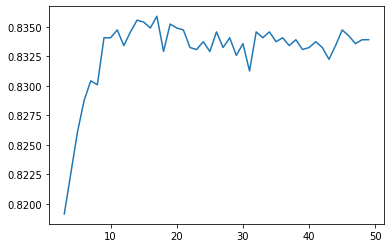

In [130]:
plt.plot(range(3,50),acc)
plt.show()

In [133]:
(np.array(acc)).max()

0.8359025360517156

In [134]:
acc.index(0.8359025360517156)

14

In [135]:
n_neighbors = np.arange(3,50)
p = [1,2]

knn_param = dict(n_neighbors=n_neighbors,p=p)

In [136]:
knn = KNeighborsClassifier()

In [137]:
rscv_knn = RandomizedSearchCV(estimator=knn,param_distributions=knn_param,cv=5,random_state=2022,n_iter=30)

In [138]:
rscv_knn.fit(X_train_std, y_train)

KeyboardInterrupt: 

### Text Mining

In [18]:
import nltk   # natural language tool kit

In [19]:
# nltk.download()

In [20]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\kandanulus\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [21]:
from nltk.corpus import twitter_samples

In [22]:
twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

In [23]:
nltk.corpus.names.fileids()

['female.txt', 'male.txt']

In [24]:
fnames = nltk.corpus.names.words('female.txt')
mnames = nltk.corpus.names.words('male.txt')

In [13]:
len(mnames)

2943

In [14]:
len(fnames)

5001

In [19]:
len(mnames)+len(fnames)

7944

In [25]:
import pandas as pd

In [28]:
females = pd.DataFrame({'names':fnames})
females['gender'] = 'female' 

In [26]:
males = pd.DataFrame({'names':mnames})
males['gender'] = 'male' 

In [29]:
al_names = pd.concat([males,females])

In [30]:
al_names

,names,gender
0,Aamir,male
1,Aaron,male
2,Abbey,male
3,Abbie,male
4,Abbot,male
...,...,...
4996,Zorine,female
4997,Zsa Zsa,female
4998,Zsazsa,female
4999,Zulema,female


In [ ]:
last char
first char
no of chars
presence of alphabets
presence of vowels

In [33]:
def feature_extraction(x):
    x = x.lower()
    
    feature = {}
    
    feature['first'] = x[0]
    feature['last'] = x[-1]
    
    feature['nchar'] = len(x)
    
    return feature

In [34]:
feature_extraction('Shubham')

{'first': 's', 'last': 'm', 'nchar': 7}

In [39]:
def feature_extraction(x):
    x = x.lower()
    
    feature = {}
    
    feature['first'] = x[0]
    feature['last'] = x[-1]
    
    feature['nchar'] = len(x)
    
    feature['vowel_count'] = 0
    
    
    for char in 'abcdefghijklmnopqrstuvwxyz':
        
        feature['contains ' + char] = char in x
        
        feature['count of ' + char] = x.count(char)
        
        if (char in 'aeiou') & (char in x):
            
            feature['vowel_count'] += x.count(char)
    if feature['vowel_count']>0:
        feature['vowels'] = 1
        
    else:
        feature['vowels'] = 0
    return feature


In [12]:
feature_extraction('Shubham')

NameError: name 'feature_extraction' is not defined

In [44]:
pd.DataFrame(feature_extraction('Shubham').values(),index=feature_extraction('Shubham').keys()).T

,first,last,nchar,vowel_count,contains a,count of a,contains b,count of b,contains c,count of c,...,count of v,contains w,count of w,contains x,count of x,contains y,count of y,contains z,count of z,vowels
0,s,m,7,2,True,1,True,1,False,0,...,0,False,0,False,0,False,0,False,0,1


In [39]:
labeled_list = [(name, 'female') for name in fnames] + [(name, 'male') for name in mnames] 

In [34]:
labeled_list[:10]

[('Abagael', 'female'),
 ('Abagail', 'female'),
 ('Abbe', 'female'),
 ('Abbey', 'female'),
 ('Abbi', 'female'),
 ('Abbie', 'female'),
 ('Abby', 'female'),
 ('Abigael', 'female'),
 ('Abigail', 'female'),
 ('Abigale', 'female')]

In [40]:
feature_list = [(feature_extraction(name),gender)  for name, gender in labeled_list]

NameError: name 'feature_extraction' is not defined

In [41]:
feature_list[0]

NameError: name 'feature_list' is not defined

In [35]:
import random

In [36]:
random.shuffle(feature_list)

NameError: name 'feature_list' is not defined

In [54]:
len(feature_list)

7944

In [55]:
train, test = feature_list[:7000], feature_list[7000:]

In [56]:
clf = nltk.NaiveBayesClassifier.train(train)

In [57]:
clf.classify(feature_extraction('Shubham'))

'male'

In [62]:
pred = clf.classify_many([feature for feature, label in test])

In [63]:
actual =  [label for feature, label in test]

In [64]:
pd.crosstab(pd.Series(actual),pd.Series(pred))

col_0,female,male
row_0,,
female,497,113
male,102,232


In [65]:
(497+232)/len(actual)

0.7722457627118644

In [67]:
xxx = [({12:13,13:14},'male'),({1:2,2:3},'female'),({34:45,45:67},'male'),({12:11,111:333},'male')]

In [68]:
xxx

[({12: 13, 13: 14}, 'male'),
 ({1: 2, 2: 3}, 'female'),
 ({34: 45, 45: 67}, 'male'),
 ({12: 11, 111: 333}, 'male')]

In [69]:
[i for i in xxx]

[({12: 13, 13: 14}, 'male'),
 ({1: 2, 2: 3}, 'female'),
 ({34: 45, 45: 67}, 'male'),
 ({12: 11, 111: 333}, 'male')]

In [70]:
[i for i,j in xxx]

[{12: 13, 13: 14}, {1: 2, 2: 3}, {34: 45, 45: 67}, {12: 11, 111: 333}]

In [71]:
[j for i,j in xxx]

['male', 'female', 'male', 'male']

In [42]:
twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

In [43]:
strings = twitter_samples.strings('positive_tweets.json')

In [44]:
tokenized = twitter_samples.tokenized('positive_tweets.json')

In [45]:
tokenized[0]

['#FollowFriday',
 '@France_Inte',
 '@PKuchly57',
 '@Milipol_Paris',
 'for',
 'being',
 'top',
 'engaged',
 'members',
 'in',
 'my',
 'community',
 'this',
 'week',
 ':)']

In [46]:
from nltk.corpus import stopwords

In [47]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [48]:
from string import punctuation

In [49]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [50]:
punctuation = [l for l in punctuation if l not in ['?','!']]

In [51]:
[w for w in tokenized[0] if w not in punctuation]

['#FollowFriday',
 '@France_Inte',
 '@PKuchly57',
 '@Milipol_Paris',
 'for',
 'being',
 'top',
 'engaged',
 'members',
 'in',
 'my',
 'community',
 'this',
 'week',
 ':)']

In [52]:
tokenized[2]

['@DespiteOfficial',
 'we',
 'had',
 'a',
 'listen',
 'last',
 'night',
 ':)',
 'As',
 'You',
 'Bleed',
 'is',
 'an',
 'amazing',
 'track',
 '.',
 'When',
 'are',
 'you',
 'in',
 'Scotland',
 '?',
 '!']

In [53]:
import re

In [54]:
[w for w in tokenized[2] if not re.search('@[A-Za-z0-9]*',w)]

['we',
 'had',
 'a',
 'listen',
 'last',
 'night',
 ':)',
 'As',
 'You',
 'Bleed',
 'is',
 'an',
 'amazing',
 'track',
 '.',
 'When',
 'are',
 'you',
 'in',
 'Scotland',
 '?',
 '!']

In [55]:
tokenized_pos = twitter_samples.tokenized('positive_tweets.json')

In [56]:
token_pos_clean = []

for i in range(0, len(tokenized_pos)):
    lst = [w for w in tokenized_pos[i] if w not in punctuation]
    lst1 = [w for w in lst if w not in stopwords.words('english')]
    lst2 = [w for w in lst1 if not re.search('@[A-Za-z0-9]*',w)]
    token_pos_clean.append(lst2)

In [57]:
tokenized_neg = twitter_samples.tokenized('negative_tweets.json')

In [58]:
token_neg_clean = []

for i in range(0, len(tokenized_neg)):
    lst = [w for w in tokenized_neg[i] if w not in punctuation]
    lst1 = [w for w in lst if w not in stopwords.words('english')]
    lst2 = [w for w in lst1 if not re.search('@[A-Za-z0-9]*',w)]
    token_pos_clean.append(lst2)

In [60]:
labelled_tweets = ([(word, 'positive') for word in token_pos_clean] + [(word, 'negative') for word in token_neg_clean])

In [61]:
words = []
for i in range(0,len(labelled_tweets)):
    
    x = labelled_tweets[i][0]
    
    for y in x:
        words.append(y.lower)

In [62]:
words = []
for i in range(0,len(labelled_tweets)):
    
    x = labelled_tweets[i][0]
    
    for y in x:
        words.append(y.lower())

In [63]:
len(set(words))

14557

In [65]:
word_feature  = {w for w in words}

In [66]:
all_words = nltk.FreqDist(w.lower() for w in words)

In [67]:
all_words

FreqDist({':(': 4586, ':)': 3693, '!': 2675, 'i': 2477, '?': 1225, ':-)': 701, ':d': 658, '...': 622, "i'm": 526, ':-(': 501, ...})

In [ ]:
##Feature Generation

In [68]:
def document_feature(document):
    
    document_words = set(document)
    
    feature = {}
    
    for word in list(word_feature):
        feature['contains({})'.format(word)] = (word in document_words)
    return feature

In [69]:
labelled_tweets[0][0]

['#FollowFriday', 'top', 'engaged', 'members', 'community', 'week', ':)']

In [70]:
featuresets = []
for (i,j) in labelled_tweets:
    
    x = document_feature(i)
    featuresets.append((x,j))

In [71]:
import random

In [72]:
random.seed(2022)

In [73]:
random.shuffle(featuresets)

In [74]:
train, test = featuresets[1000:10000], featuresets[:1000]

In [75]:
classifier = nltk.NaiveBayesClassifier.train(train)

In [ ]:
print(nltk.classify.accuracy(classifier,test))

In [78]:
collection = ['it was best of the times',
              'it was worst of the times',
              'it was age of wisdom',
              'it was age of foolishness']

In [79]:
vacab = list(set(' '.join(collection).split()))

In [80]:
from sklearn.feature_extraction.text import CountVectorizer

In [81]:
bow = CountVectorizer()

In [82]:
x = bow.fit_transform(collection)

In [83]:
x.toarray()

array([[0, 1, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 0, 1, 1, 0],
       [1, 0, 1, 1, 1, 0, 0, 1, 0, 0]], dtype=int64)

In [84]:
bow.get_feature_names_out()

array(['age', 'best', 'foolishness', 'it', 'of', 'the', 'times', 'was',
       'wisdom', 'worst'], dtype=object)

In [85]:
import pandas as pd

In [87]:
collection

['it was best of the times',
 'it was worst of the times',
 'it was age of wisdom',
 'it was age of foolishness']

In [86]:
pd.DataFrame(x.toarray(), columns=bow.get_feature_names_out())

,age,best,foolishness,it,of,the,times,was,wisdom,worst
0,0,1,0,1,1,1,1,1,0,0
1,0,0,0,1,1,1,1,1,0,1
2,1,0,0,1,1,0,0,1,1,0
3,1,0,1,1,1,0,0,1,0,0


In [ ]:
TFIDF

In [88]:
TF: Term Frequency - ratio of count of words present in a sentence to the length of the sentence
IDF: Inverse Document Frequency - IDF = log(N/n)
N = total no of rows
n = no of rows in which the word is present
TFIDF = TF * IDF

SyntaxError: invalid syntax (2820865167.py, line 1)

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [92]:
tfidf = TfidfVectorizer()

In [93]:
ccc = tfidf.fit_transform(collection)

In [94]:
pd.DataFrame(ccc.toarray(),columns=tfidf.get_feature_names_out())

,age,best,foolishness,it,of,the,times,was,wisdom,worst
0,0.000000,0.571649,0.000000,0.298310,0.298310,0.450694,0.450694,0.298310,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.298310,0.298310,0.450694,0.450694,0.298310,0.000000,0.571649
2,0.504879,0.000000,0.000000,0.334174,0.334174,0.000000,0.000000,0.334174,0.640375,0.000000
3,0.504879,0.000000,0.640375,0.334174,0.334174,0.000000,0.000000,0.334174,0.000000,0.000000


In [95]:
tfidf.get_feature_names_out()

array(['age', 'best', 'foolishness', 'it', 'of', 'the', 'times', 'was',
       'wisdom', 'worst'], dtype=object)

In [98]:
file = open('text_learning.txt')
text = file.read()

In [99]:
print(text)

The data in this example consists of movie ratings from Twitter since 2013, updated daily. The data was created from people who connected their IMDB profile with their Twitter accounts. Whenever they rated a movie on the IMDB website, an automated process generated a standard, well-structured tweet.


In [101]:
file.seek(1)

1

In [104]:
file = open('new_file.txt','w')
file.write('I like programming')
file.write('\ni like Machine learning')
file.close()

In [105]:
f = open('new_file.txt','r')

In [108]:
print(f.read())

I like programming
i like Machine learning


In [110]:
f.seek(0)
print(f.read())

I like programming
i like Machine learning


In [111]:
f.seek(0)
print(f.readline())

I like programming



In [112]:
f.seek(1)
print(f.readline())

 like programming



In [114]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [117]:
import matplotlib.pyplot as plt

In [116]:
from wordcloud import WordCloud, STOPWORDS

In [118]:
wc = WordCloud(stopwords = list(STOPWORDS))
wc.generate(text)

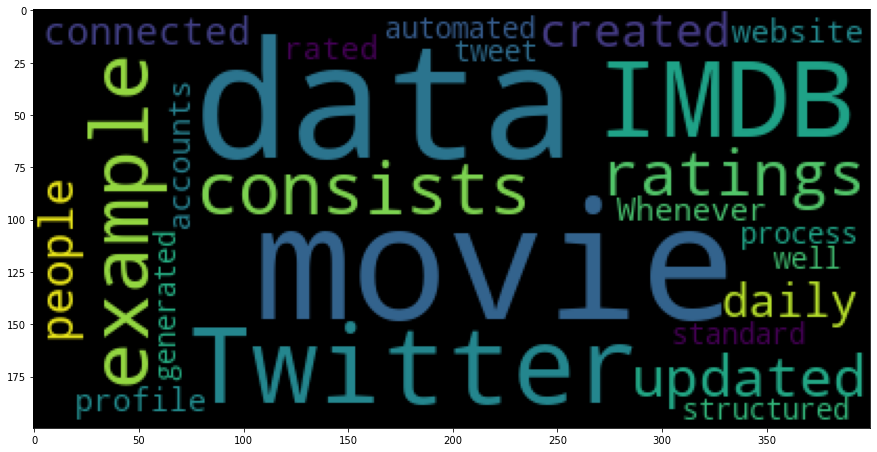

In [120]:
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.show()

In [ ]:
### Limitization and stemming

In [126]:
play
plays
played
playing

NameError: name 'play' is not defined

In [130]:
nltk.stem.PorterStemmer()

<PorterStemmer>

In [141]:
stemming = nltk.stem.PorterStemmer()

In [131]:
stemming.stem('plays')

'play'

In [132]:
stemming.stem('played')

'play'

In [133]:
stemming.stem('playing')

'play'

In [134]:
stemming.stem('Corpora')

'corpora'

In [139]:
lemm = nltk.stem.WordNetLemmatizer()

In [140]:
lemm.lemmatize('corpora')

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - 'C:\\Users\\kandanulus/nltk_data'
    - 'C:\\Users\\kandanulus\\Anaconda3\\nltk_data'
    - 'C:\\Users\\kandanulus\\Anaconda3\\share\\nltk_data'
    - 'C:\\Users\\kandanulus\\Anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\kandanulus\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [142]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

In [143]:
df = pd.DataFrame({'user_0':[0,3,0,5,0,0,4,5,0,2], 'user_1':[0,0,3,2,5,0,4,0,3,0], 'user_2':[3,1,0,3,5,0,0,4,0,0], 'user_3':[4,3,4,2,0,0,0,2,0,0],'user_4':[2,0,0,0,0,4,4,3,5,0], 'user_5':[1,0,2,4,0,0,4,0,5,0], 'user_6':[2,0,0,3,0,4,3,3,0,0], 'user_7':[0,0,0,3,0,2,4,3,4,0],'user_8':[5,0,0,0,5,3,0,3,0,4], 'user_9':[1,0,2,0,4,0,4,3,0,0]}, index=['movie_0','movie_1','movie_2','movie_3','movie_4','movie_5','movie_6','movie_7','movie_8','movie_9'])


In [144]:
df

,user_0,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9
movie_0,0,0,3,4,2,1,2,0,5,1
movie_1,3,0,1,3,0,0,0,0,0,0
movie_2,0,3,0,4,0,2,0,0,0,2
movie_3,5,2,3,2,0,4,3,3,0,0
movie_4,0,5,5,0,0,0,0,0,5,4
movie_5,0,0,0,0,4,0,4,2,3,0
movie_6,4,4,0,0,4,4,3,4,0,4
movie_7,5,0,4,2,3,0,3,3,3,3
movie_8,0,3,0,0,5,5,0,4,0,0
movie_9,2,0,0,0,0,0,0,0,4,0


In [145]:
# after making sure the ratings are centred around zero

In [150]:
df_users = df.T

In [151]:
df_users

,movie_0,movie_1,movie_2,movie_3,movie_4,movie_5,movie_6,movie_7,movie_8,movie_9
user_0,0,3,0,5,0,0,4,5,0,2
user_1,0,0,3,2,5,0,4,0,3,0
user_2,3,1,0,3,5,0,0,4,0,0
user_3,4,3,4,2,0,0,0,2,0,0
user_4,2,0,0,0,0,4,4,3,5,0
user_5,1,0,2,4,0,0,4,0,5,0
user_6,2,0,0,3,0,4,3,3,0,0
user_7,0,0,0,3,0,2,4,3,4,0
user_8,5,0,0,0,5,3,0,3,0,4
user_9,1,0,2,0,4,0,4,3,0,0


In [152]:
user = df_users.loc[['user_0']]

In [153]:
user

,movie_0,movie_1,movie_2,movie_3,movie_4,movie_5,movie_6,movie_7,movie_8,movie_9
user_0,0,3,0,5,0,0,4,5,0,2


In [154]:
others = df_users[df_users.index != 'user_0']
others

,movie_0,movie_1,movie_2,movie_3,movie_4,movie_5,movie_6,movie_7,movie_8,movie_9
user_1,0,0,3,2,5,0,4,0,3,0
user_2,3,1,0,3,5,0,0,4,0,0
user_3,4,3,4,2,0,0,0,2,0,0
user_4,2,0,0,0,0,4,4,3,5,0
user_5,1,0,2,4,0,0,4,0,5,0
user_6,2,0,0,3,0,4,3,3,0,0
user_7,0,0,0,3,0,2,4,3,4,0
user_8,5,0,0,0,5,3,0,3,0,4
user_9,1,0,2,0,4,0,4,3,0,0


In [155]:
cosine_similarity(user,others)

array([[0.36854415, 0.55194325, 0.46610784, 0.41686855, 0.5143907 ,
        0.68926594, 0.70428333, 0.28234145, 0.514244  ]])

In [156]:
cosine_distances(user,others)

array([[0.63145585, 0.44805675, 0.53389216, 0.58313145, 0.4856093 ,
        0.31073406, 0.29571667, 0.71765855, 0.485756  ]])

In [158]:
user_0 - (user_7,user_6)

NameError: name 'user_0' is not defined